# **Text Mining on Dutch party programmes**

## **Define paths**

In [5]:
pdf_folder = 'data/vkps/total_vkps'
text_folder = 'data/vkps_texts'
folia_folder = 'data/folias'
plot_directory = "outputs/plots/topics_without_non_thematic"

## **Convert pdf's to text files**

In [4]:
from parsing.pdf_to_txt import pdf_to_text

files = os.listdir(pdf_folder)
for file_name in files:
    if file_name.endswith('.pdf'):
        pdf_path = os.path.join(pdf_folder, file_name)
        text_path = os.path.join(text_folder, file_name.replace('.pdf', '.txt'))
        pdf_to_text(pdf_path, text_path)
        print(f"Converted {file_name} to text.")


Converted BVNL.pdf to text.
Converted GL_PvdA.pdf to text.
Converted D66.pdf to text.
Converted BBB.pdf to text.
Converted SGP.pdf to text.
Converted PVDS.pdf to text.
Converted CDA.pdf to text.
Converted NSC.pdf to text.
Converted 50plus.pdf to text.
Converted PVV.pdf to text.
Converted VVD.pdf to text.
Converted FvD.pdf to text.
Converted JA21.pdf to text.
Converted CU.pdf to text.
Converted SP.pdf to text.
Converted Volt.pdf to text.
Converted PvdD.pdf to text.
Converted Piratenpartij.pdf to text.
Converted LP.pdf to text.


## **Convert text files to folia**

In [5]:
from parsing.txt_to_folia import txt_to_folia
txt_to_folia(text_folder, folia_folder)

looping through text files: 100%|██████████| 19/19 [00:04<00:00,  4.62it/s]


## **Classify sentences**

In [5]:
from classifying.folia_to_classification import *

dfs = []
for folia_f in list_folia_files(folia_folder):
    p = f"{folia_folder}/{folia_f}"
    party_name = folia_f.replace('.folia.xml', '')
    df_party = process_folia_file(p, party_name)
    dfs.append(df_party)

df = pd.concat(dfs, ignore_index=True)

# Calculate the number of sentences per party
df['total_sentences'] = df.groupby('party')['sentence'].transform('count')

# Calculate the number of sentences per topic within each party
df['topic_sentences'] = df.groupby(['party', 'primary_topic'])['sentence'].transform('count')

# Calculate the percentage of sentences per topic for each party
df['topic_percentage'] = (df['topic_sentences'] / df['total_sentences']) * 100

# Calculate the average percentage for each topic across all parties
average_topic_percentage = df.groupby('primary_topic')['topic_percentage'].mean().reset_index(name='average_percentage')

# Merge the average percentage back to the main dataframe
df = df.merge(average_topic_percentage, on='primary_topic')

# Calculate the relative difference for each party and topic
df['relative_difference'] = (df['topic_percentage'] - df['average_percentage']) / df['average_percentage'] * 100

# Now you can use `df` to analyze the attention per topic, the average attention, and the relative differences.


100%|██████████| 1934/1934 [01:46<00:00, 18.23it/s]


In [6]:
# Concatenate the DataFrames of sentences
df = pd.concat(dfs, ignore_index=True)
df['primary_topic'] = df['primary_topic'].str.replace('\d+', '', regex=True)
df['primary_topic'] = df['primary_topic'].str.replace('\.', '', regex=True)
df['primary_topic'] = df['primary_topic'].str.replace('\-', '', regex=True)
df['primary_topic'] = df['primary_topic'].str.strip()

# Create a DataFrame with counts of each topic per party
topic_counts = df.groupby(['party', 'primary_topic']).size().reset_index(name='topic_count')

# Calculate the total number of thematic sentences per party
total_sentences_per_party = df.groupby('party').size().reset_index(name='total_sentences')

# Merge to get the total sentences in the topic_counts DataFrame
topic_counts = topic_counts.merge(total_sentences_per_party, on='party')

# Calculate the percentage of sentences per topic for each party and round to one decimal
topic_counts['topic_percentage'] = ((topic_counts['topic_count'] / topic_counts['total_sentences']) * 100).round(1)

# Calculate the average percentage for each topic across all parties and round to one decimal
average_topic_percentage = topic_counts.groupby('primary_topic')['topic_percentage'].mean().reset_index(name='average_percentage')
average_topic_percentage['average_percentage'] = average_topic_percentage['average_percentage'].round(1)

# Merge the average percentage back to the topic_counts DataFrame
topic_counts = topic_counts.merge(average_topic_percentage, on='primary_topic')

# Calculate the relative difference for each party and topic and round to one decimal
topic_counts['relative_difference'] = ((topic_counts['topic_percentage'] - topic_counts['average_percentage']) / topic_counts['average_percentage'] * 100).round(0)

In [8]:
topic_counts = topic_counts.sort_values(by="party")
topic_counts.to_csv("party_topics_without_non_thematic.csv", index=False)

## **Plot party attention profiles**

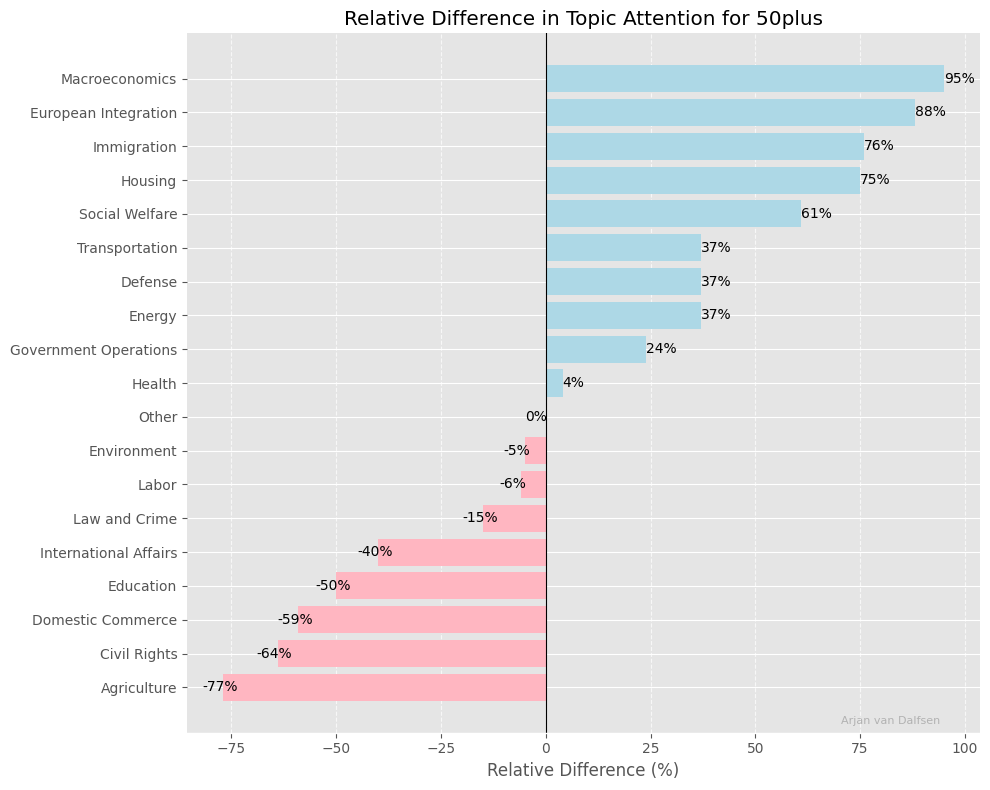

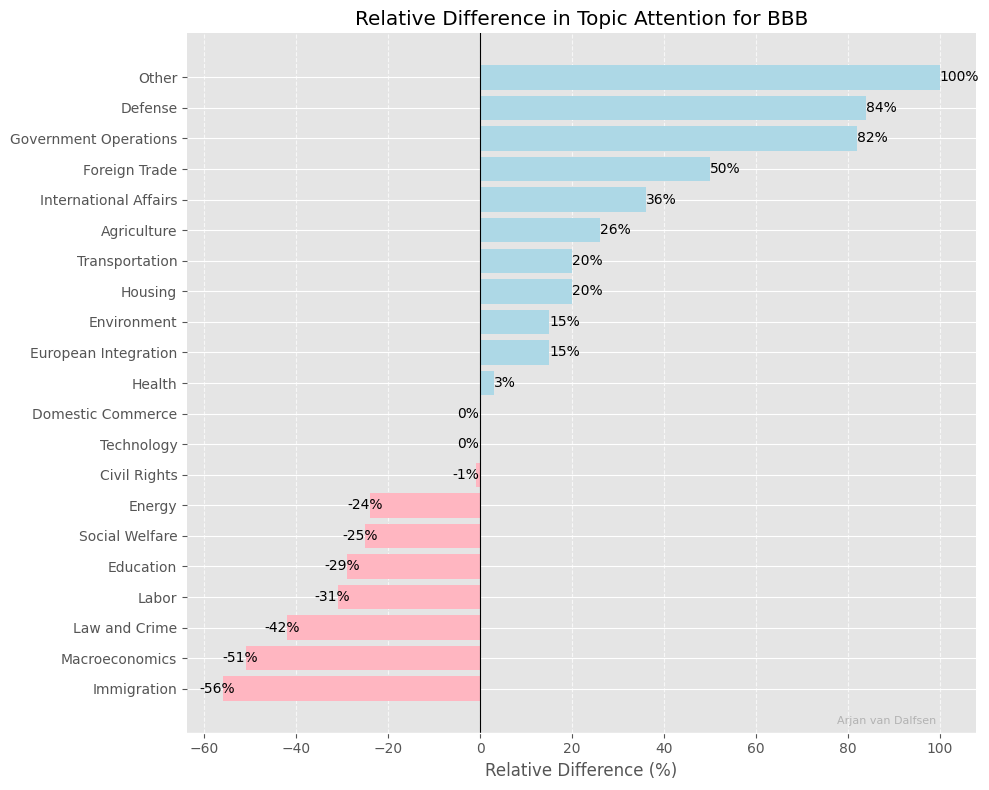

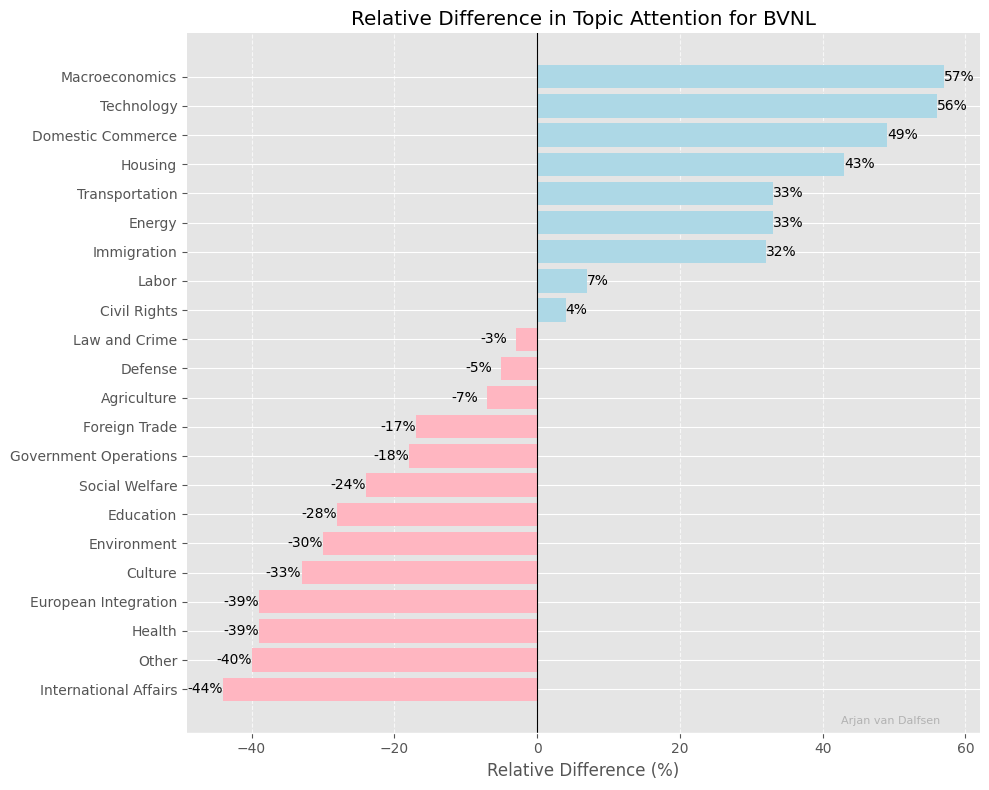

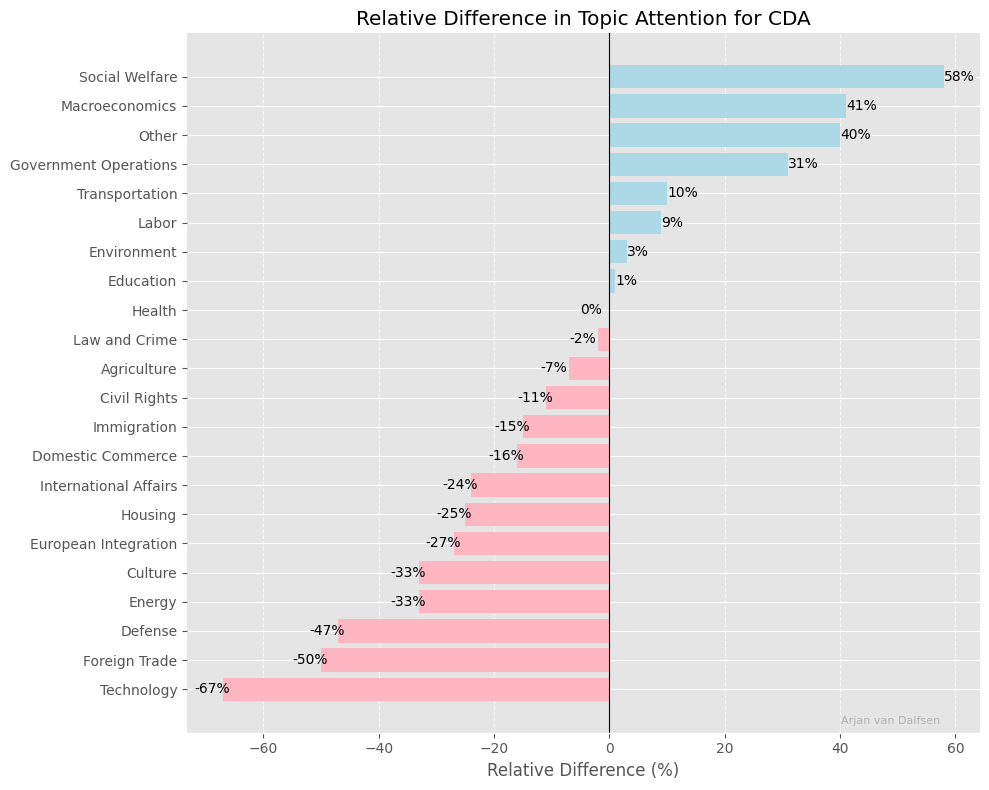

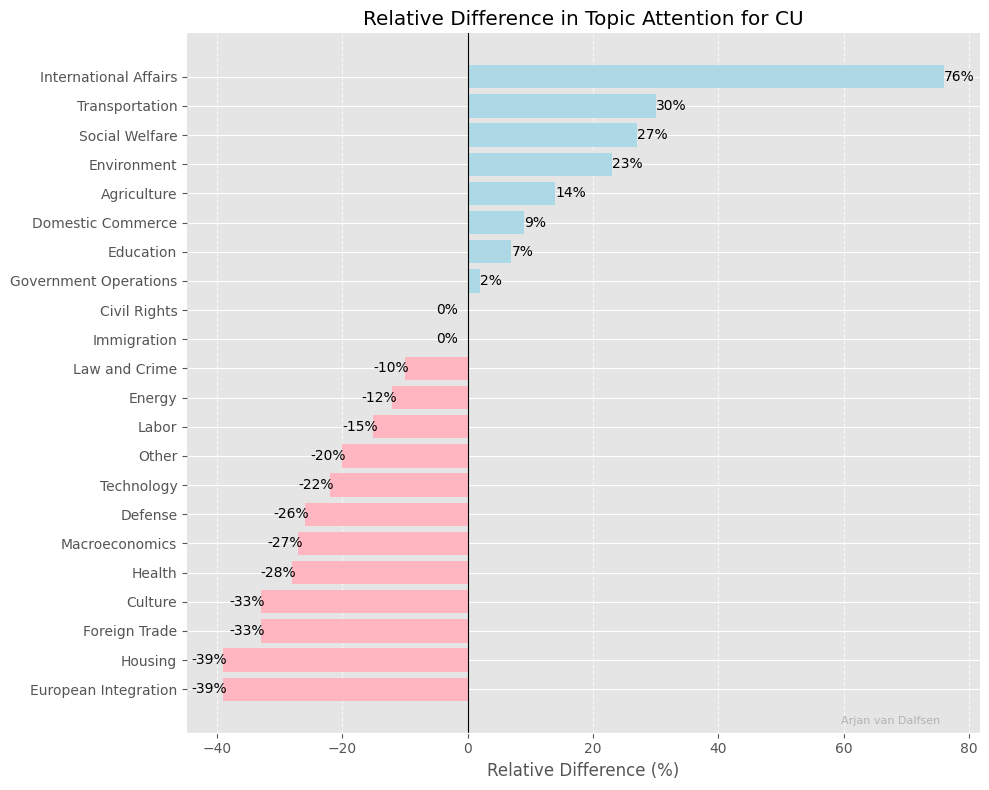

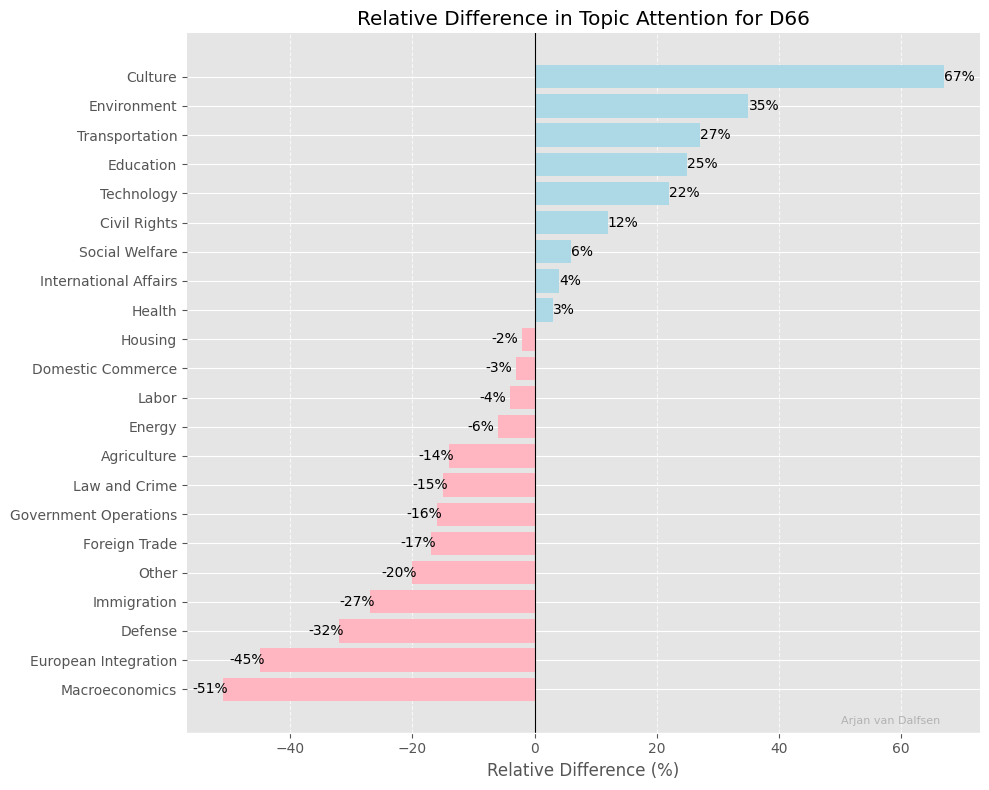

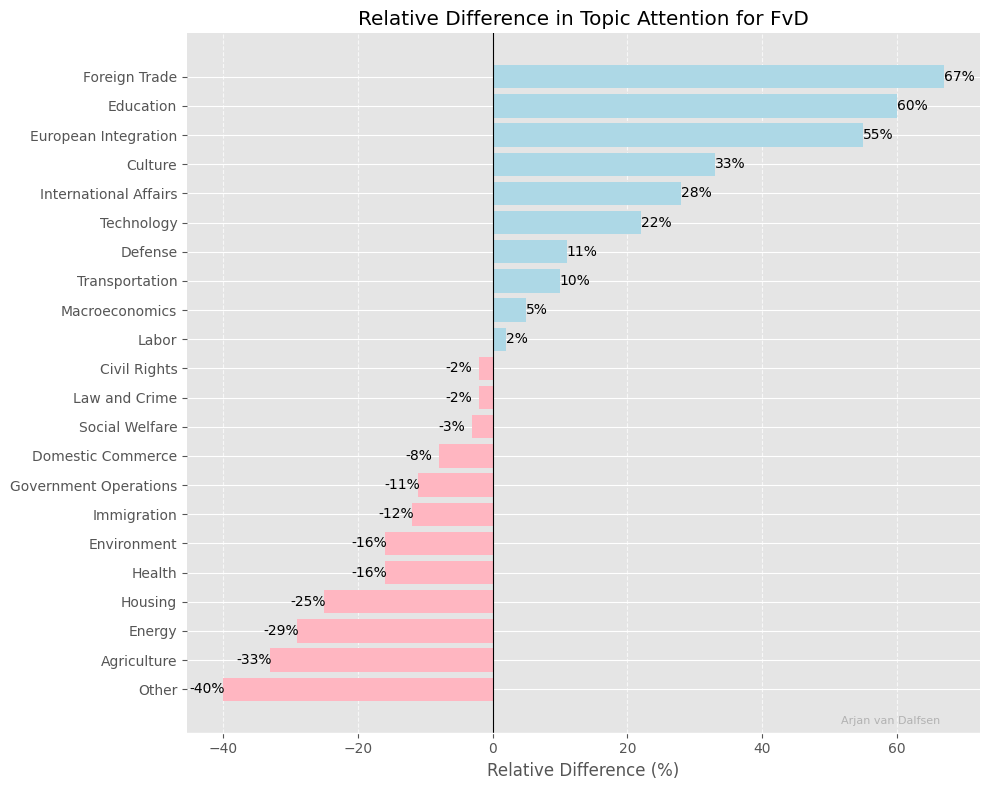

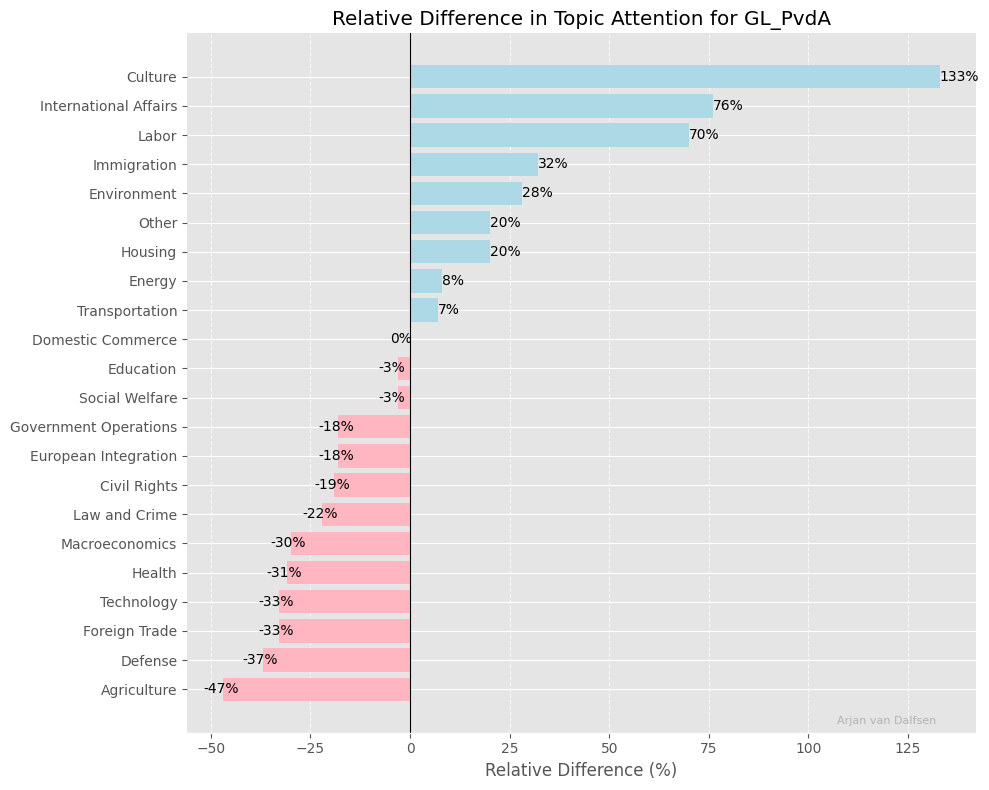

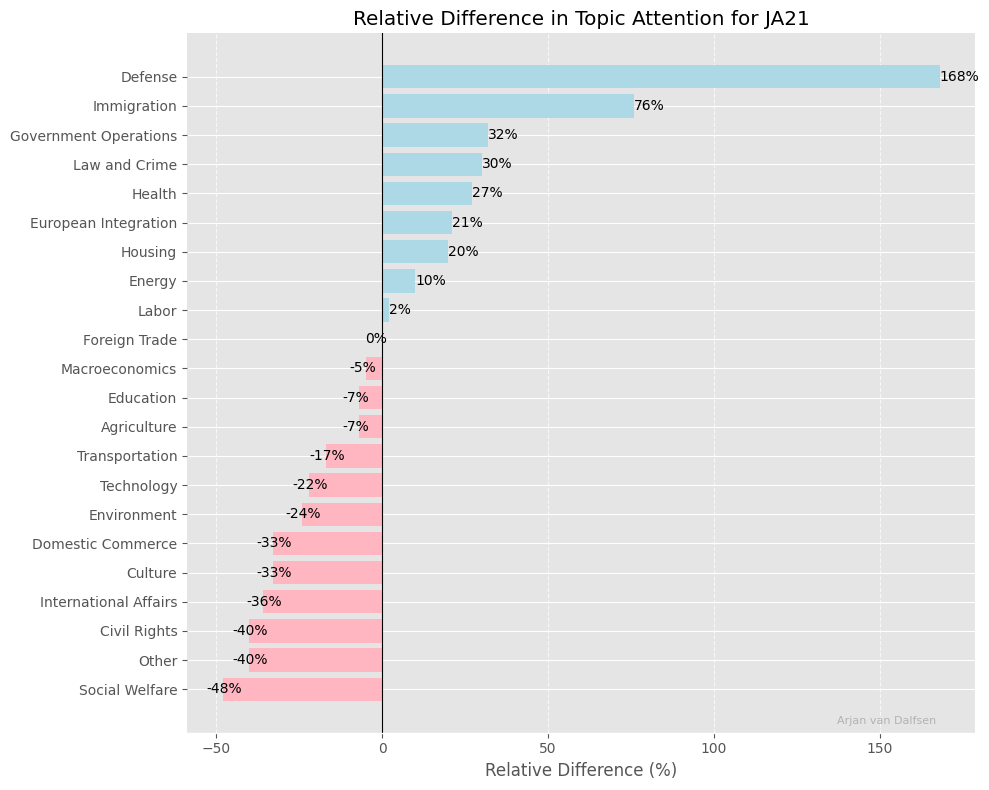

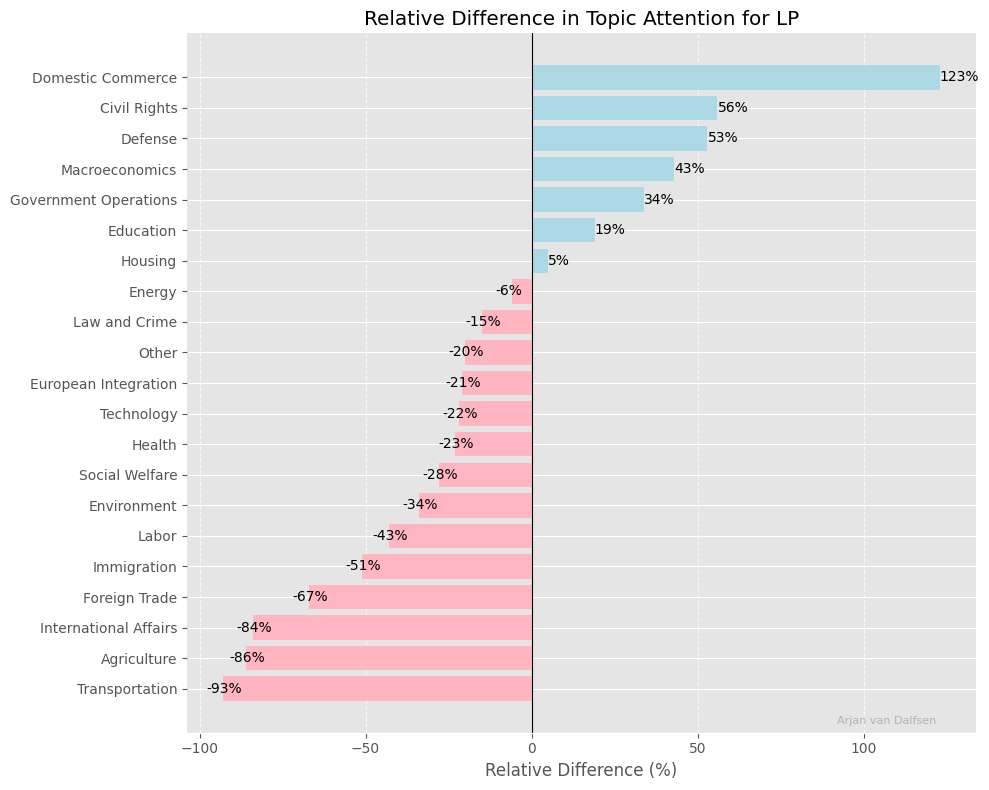

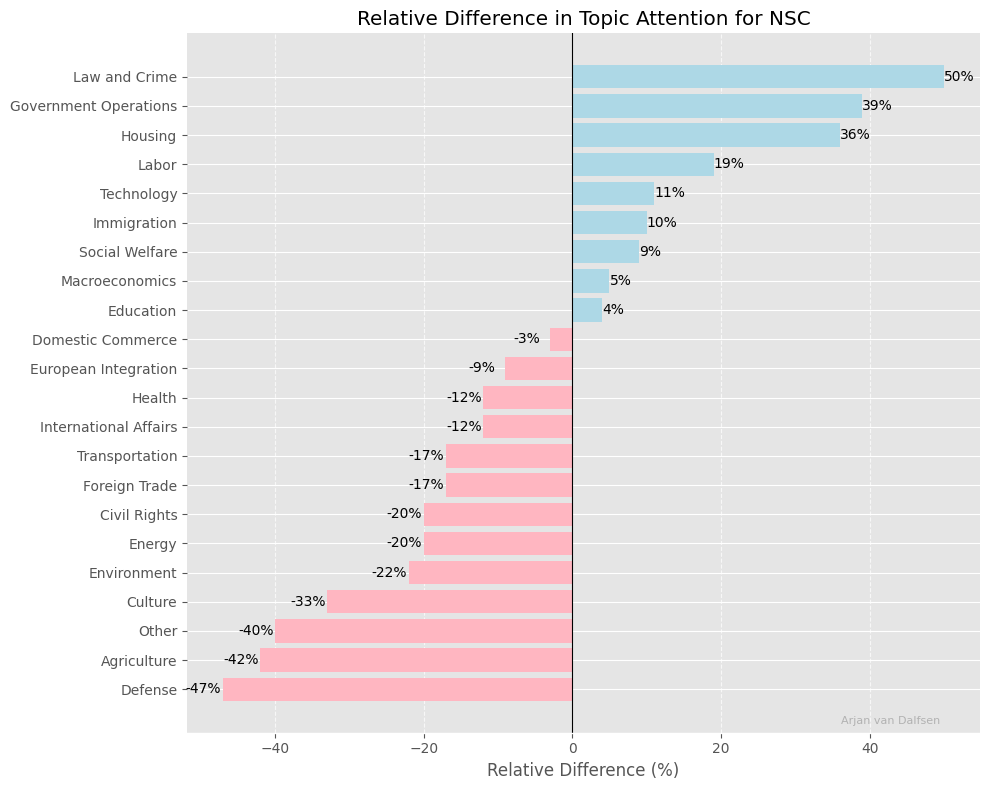

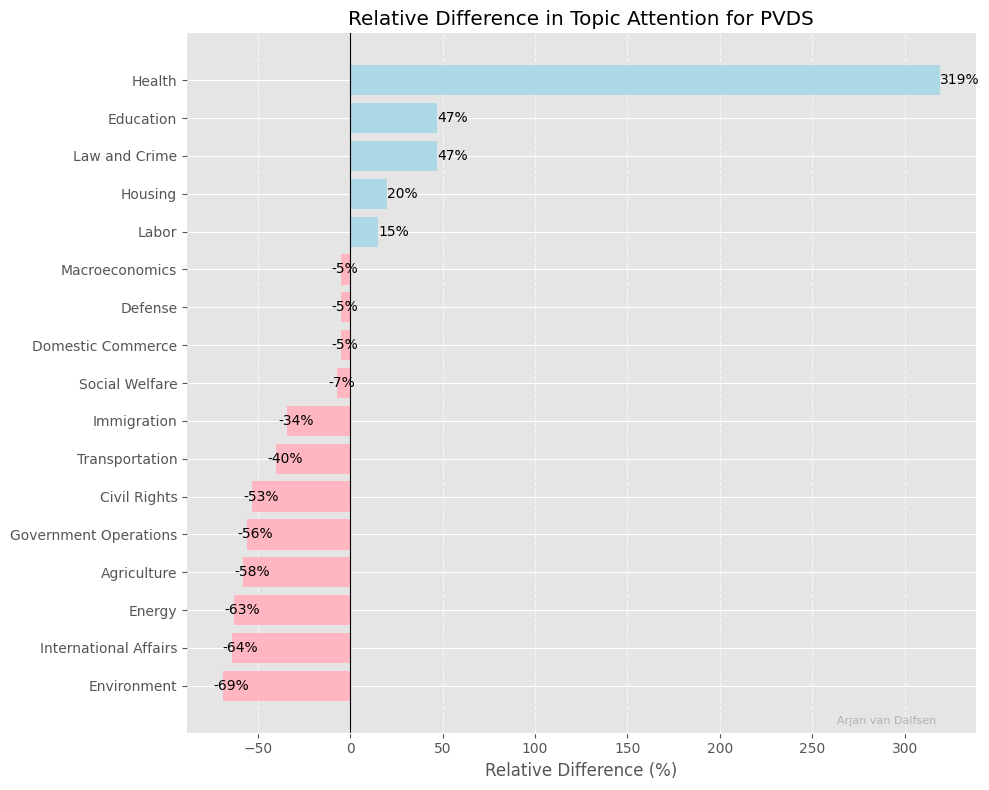

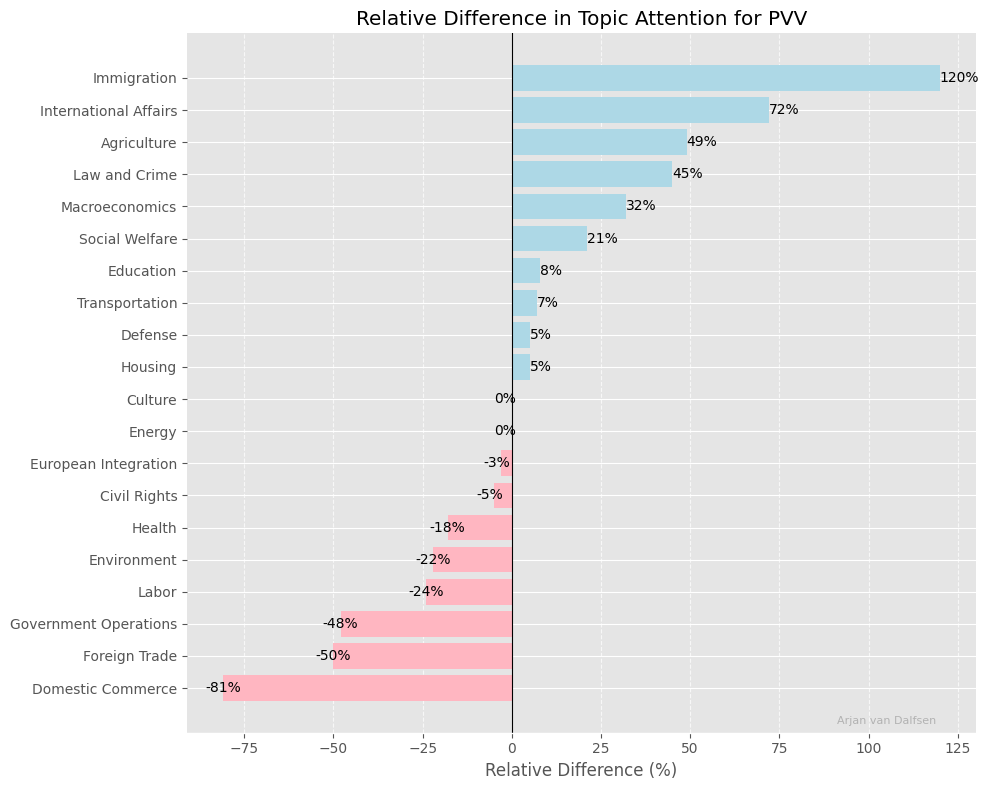

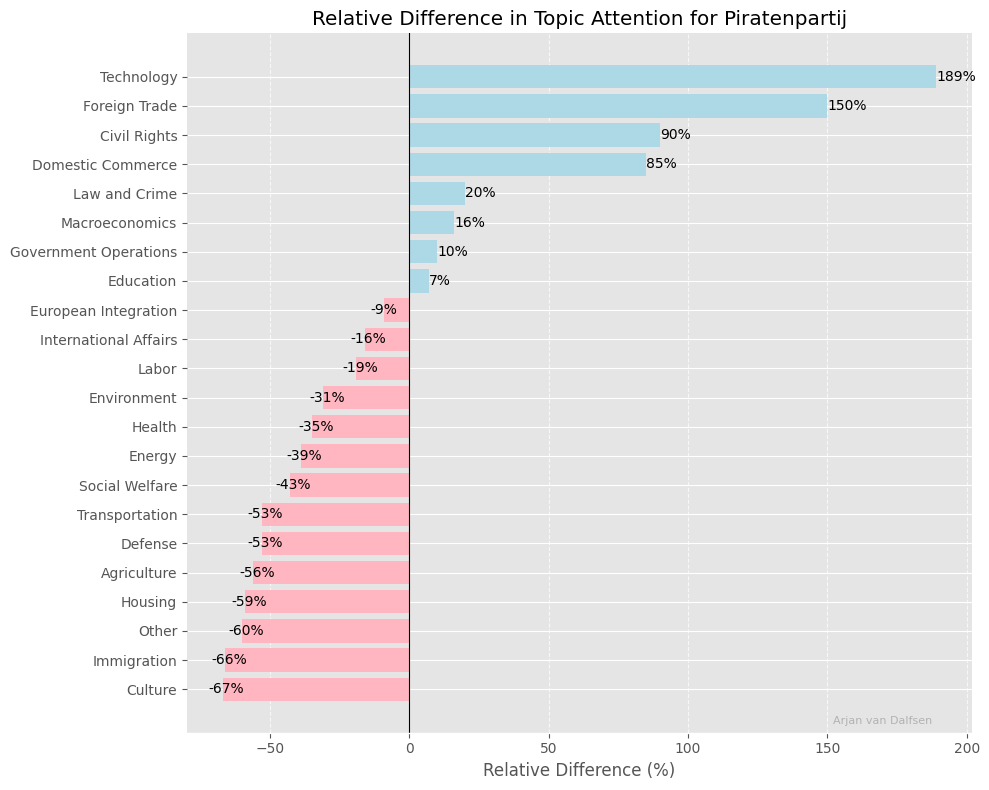

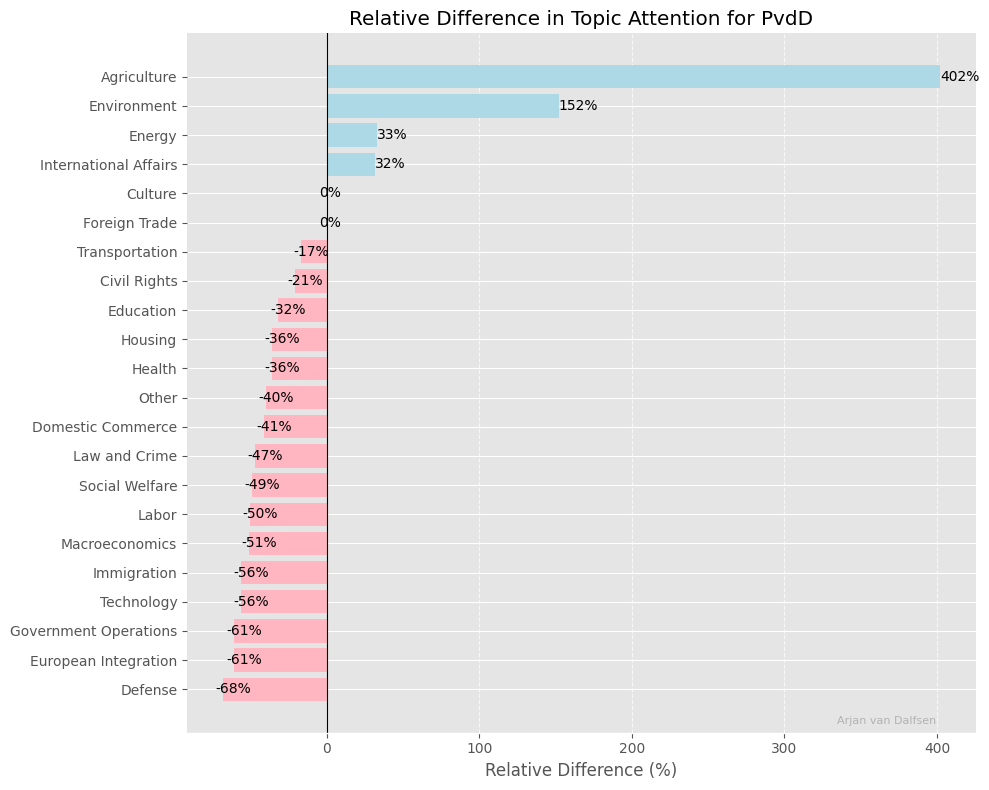

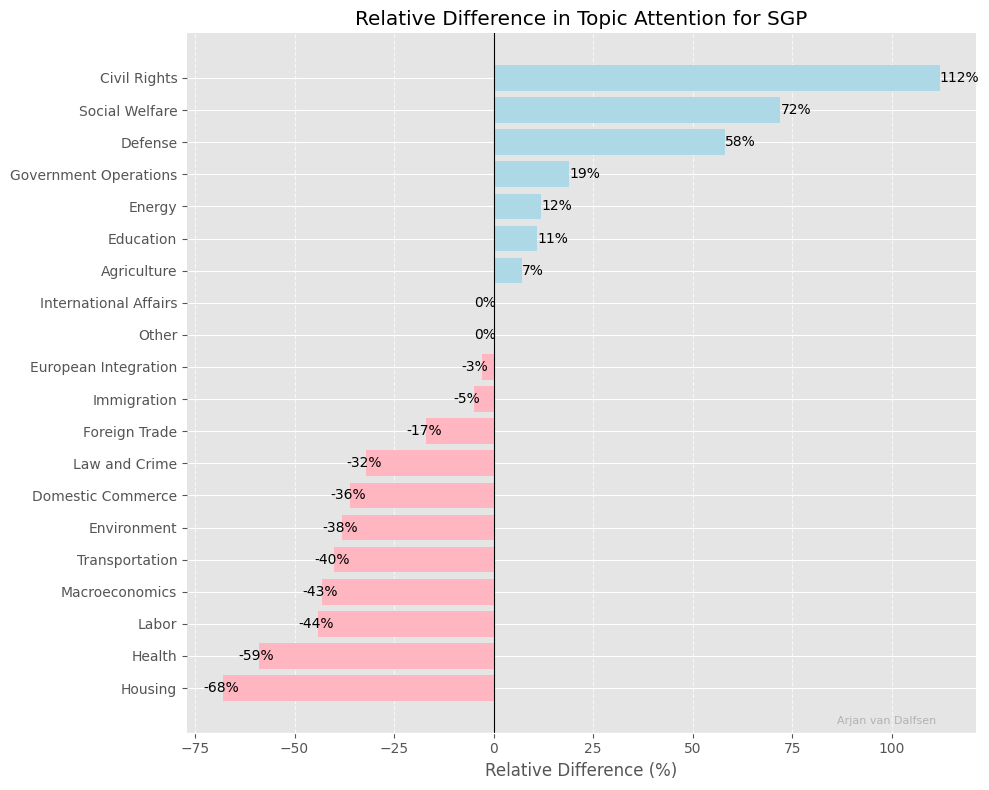

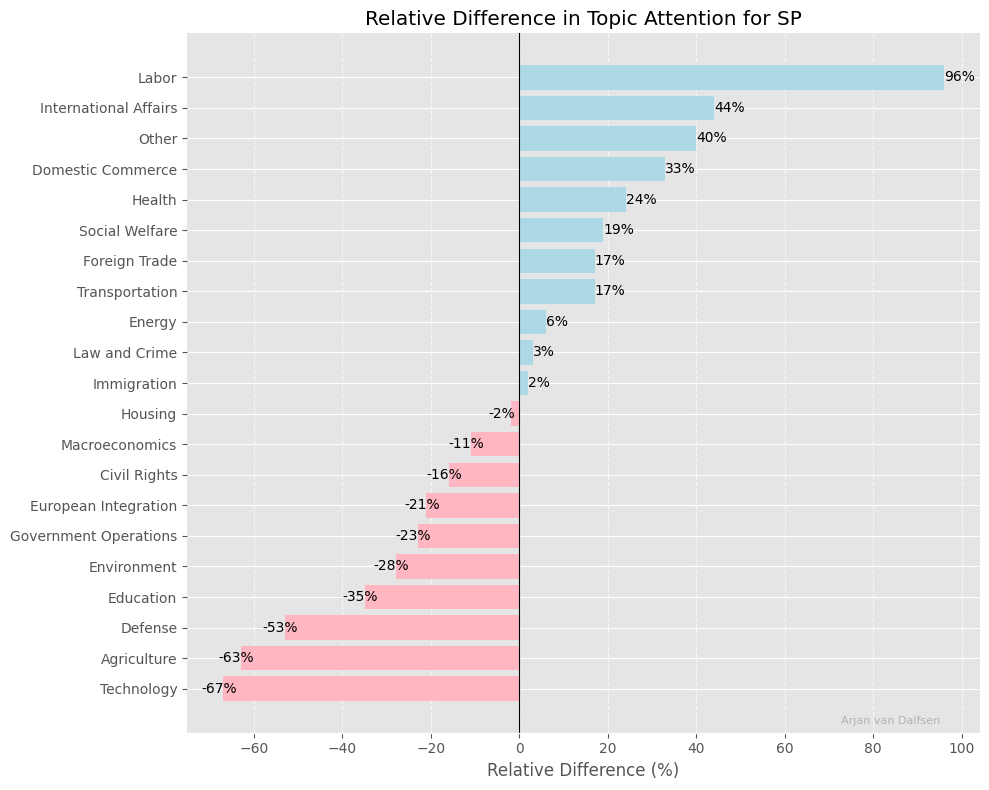

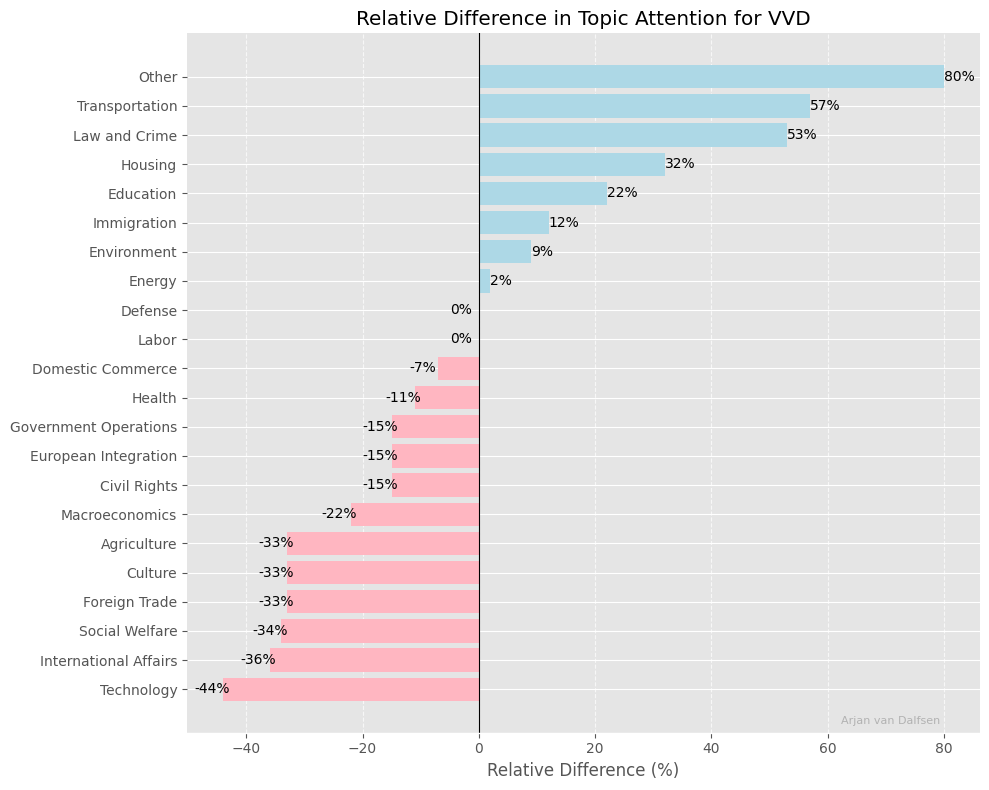

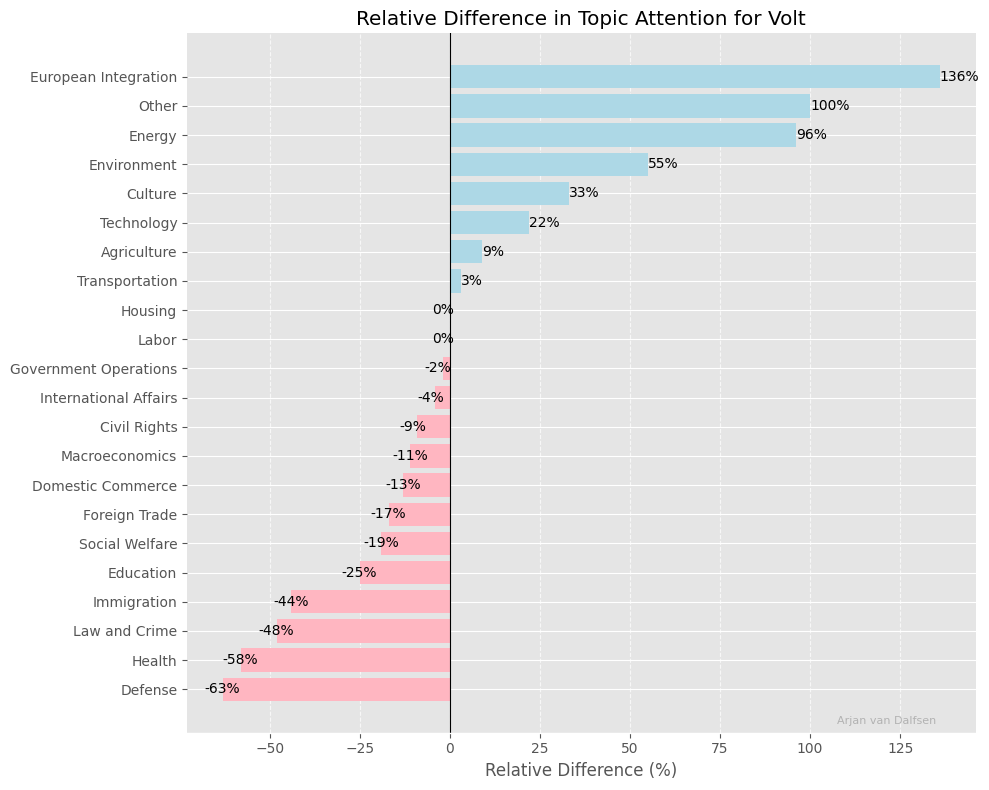

In [13]:
import matplotlib.pyplot as plt

# Set the style for the plots
plt.style.use('ggplot')

# Unique list of parties
parties = topic_counts['party'].unique()

for party in parties:
    # Filter the DataFrame for the current party
    party_data = topic_counts[topic_counts['party'] == party]
    
    # Sort the topics by the relative difference to have a meaningful order in the plot
    party_data_sorted = party_data.sort_values('relative_difference', ascending=True)
    
    # Create a figure and a set of subplots
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Determine the colors for the bars based on the relative difference values
    bar_colors = ['#ffb6c1' if x < 0 else '#add8e6' for x in party_data_sorted['relative_difference']]
    
    # Create the bar plot with different colors for positive and negative values
    bars = ax.barh(party_data_sorted['primary_topic'], party_data_sorted['relative_difference'], color=bar_colors)
    
    # Draw a vertical line at x=0 separating the less and more attention
    ax.axvline(0, color='black', linewidth=0.8)
    
    # Set labels and title
    ax.set_xlabel('Relative Difference (%)')
    ax.set_title(f'Relative Difference in Topic Attention for {party}')
    
    # Remove the spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Show grid
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)

    # Annotate the bars with the percentage values
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width if width > 0 else width - 5
        ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:.0f}%', va='center')
    
    ax.text(0.95, 0.01, 'Arjan van Dalfsen',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='grey', fontsize=8, alpha=0.5)

    # Show the plot
    plt.tight_layout()

    figure_path = os.path.join(plot_directory, f'{party}.png')
    plt.savefig(figure_path, bbox_inches='tight')
    
    plt.show()